In [1]:
import pandas as pd
import json
import os
import numpy as np
import scipy.stats
from scipy.spatial import distance
import math
from math import sqrt
from sklearn.metrics.pairwise import cosine_similarity
from random import *
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from mpl_toolkits.mplot3d import Axes3D

In [2]:
def load_jsons(data_path, file):
    """ helper function to load '.json' files (they're not proper jsons) """
    file_path = data_path + file
    with open(file_path) as jsons:
        lines = [json.loads(json_line) for json_line in jsons]
    return pd.DataFrame(lines)

# Load data for town called Brooklyn
data_path = './data/brooklyn/'
review_file = 'review.json'
business_file = 'business.json'
user_file = 'user.json'
tip_file = 'tip.json'
checkin_file = 'checkin.json'

reviews = load_jsons(data_path, review_file)
businesses = load_jsons(data_path, business_file)
users = load_jsons(data_path, user_file)
tips = load_jsons(data_path, tip_file)
checkins = load_jsons(data_path, checkin_file)

In [3]:
display(reviews.head())
print('Aantal businesses in deze stad: {}'.format(len(businesses)))
print('Aantal users in deze stad: {}'.format(len(users)))
#print(len(users))
#display(businesses.head())
#display(users.head())
#print(users.columns)
#display(tips.head())
#display(checkins.head())

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,O9kJKk1ST4IsddJafyWPAw,8q9R0lX_rMebeTx0wN0c5Q,TR5UXUUH0zs8OHDc-fGNsA,4.0,0,0,0,"Penn Station\nWho has the best subs, cookie, a...",2017-08-28 20:26:51
1,3Eusinlr6KZUpexnYs_fyQ,XJc_FxvTERDC_cRaIuEfqA,pDA8NJUwGl1IoLDeaVfo0Q,1.0,0,0,0,"This theater used to be one of my favorites, b...",2013-10-03 20:52:58
2,ANm2qf0QLzYgxwHQkC5Kmg,IvYlKW4hfn7lQrV2ATcqmA,p4mAL07lzH6AMIaujSfETg,4.0,3,2,0,Learned the hard way -- don't ask for anything...,2014-02-25 09:00:32
3,8fcWf0m6_0Mgu6eP7Dk88w,O6TY9mvpcO4Pm4CTxJb7Zw,TR5UXUUH0zs8OHDc-fGNsA,5.0,0,0,0,Never had a bad meal. The staff are well train...,2016-08-25 22:42:23
4,VUzooL_8KDHdMLKNlpCuoA,APaVlvAEJDh1GrSYbKDs-w,C0i1vWllFvYjcqvbI66JKA,5.0,0,0,0,now ive been to many stores in my years but th...,2016-10-27 21:54:27


Aantal businesses in deze stad: 78
Aantal users in deze stad: 1280


In [4]:
#HELPER FUNCTIONS FOR ITEM BASED
def get_rating(reviews, business_id, user_id):
    """Given a business_id and user_id, this function returns the corresponding rating.
       Should return NaN if no rating exists."""
    
    selected = reviews[(reviews['user_id'] == user_id) & (reviews['business_id'] == business_id)]
    if selected.empty == True:
        return np.nan
    else:
        return selected['stars'].values[0]

def pivot_ratings(reviews):
    """ takes a review table as input and computes the utility matrix """
    utility_matrix = pd.DataFrame(index= set(reviews['business_id']))
    utility_matrix = utility_matrix.reindex(columns = set(reviews['user_id']))
    
    for index, row in utility_matrix.iterrows():
        for i in row.index:
            utility_matrix[i][index] = get_rating(reviews, index, i)  
    return utility_matrix

def mean_center_columns(matrix):
    means = matrix.mean()
    mean_centered_columns = matrix.copy()
    
    for index, row in mean_centered_columns.iterrows():
        for i in row.index:
            mean_centered_columns[i][index] = mean_centered_columns[i][index] - means[i]
        
    mean_centered_columns = mean_centered_columns.sort_index()
    mean_centered_columns = mean_centered_columns.reindex(sorted(mean_centered_columns.columns), axis=1)
    return mean_centered_columns

def cosine_distance(matrix, id1, id2):   
    # only take the features that have values for both id1 and id2
    selected_features = matrix.loc[id1].notna() & matrix.loc[id2].notna()
    
    # if no matching features, return 'not a number' (NaN)
    if not selected_features.any():
        return np.nan
    
    # get the features from the matrix
    features1 = matrix.loc[id1][selected_features]
    features2 = matrix.loc[id2][selected_features]
    
    if len(features1) < 5 or len(features2) < 5:
        return 1
    if features1.equals(features2):
        return 1
    
    numerator = 0
    denominator = 0
    
    for i in range(len(features1)):
        numerator += features1.values[i] * features2.values[i]
        
    denominator =  sqrt(sum(features1.values**2)) * sqrt(sum(features2.values**2))
        
    if denominator == 0:
        return np.nan
    else:
        return (numerator / denominator)

def create_similarity_matrix_cosine(matrix):
    """creates the similarity matrix based on cosine distance"""
    similarity_matrix = pd.DataFrame(0, index=matrix.index, columns=matrix.index, dtype=float)

    for index, row in similarity_matrix.iterrows():
        for i in row.index:
            similarity_matrix[i][index] = cosine_distance(matrix, i, index)
    
    similarity_matrix = similarity_matrix.sort_index()
    similarity_matrix = similarity_matrix.reindex(sorted(similarity_matrix.columns), axis=1)
    return similarity_matrix

def mean_center_columns(matrix):
    means = matrix.mean()
    mean_centered_columns = matrix.copy()
    
    for index, row in mean_centered_columns.iterrows():
        for i in row.index:
            mean_centered_columns[i][index] = mean_centered_columns[i][index] - means[i]
        
    mean_centered_columns = mean_centered_columns.sort_index()
    mean_centered_columns = mean_centered_columns.reindex(sorted(mean_centered_columns.columns), axis=1)
    return mean_centered_columns

In [5]:
def select_neighborhood(similarities, reviews, k):
    """ selects all items with similarity > 0  """
    
    sims = similarities[(similarities > 0)].index
    top_k = similarities[sims.intersection(reviews[reviews.notna()].index)]
    return top_k.nlargest(k)

def weighted_mean(neighborhood, reviews):
    numerator = 0
    sum_neighborhood = 0 
    
    for i in reviews.keys().intersection(neighborhood.keys()):
        if not math.isnan(reviews[i]):
            numerator += reviews[i] * neighborhood[i]
            sum_neighborhood += neighborhood[i]

    if sum_neighborhood == 0:
        return 0
    

    return numerator / sum_neighborhood

def split_data(data,d = 0.75):
    """ split data in a training and test set 
       `d` is the fraction of data in the training set"""
    np.random.seed(seed=5)
    mask_test = np.random.rand(data.shape[0]) < d
    return data[mask_test], data[~mask_test]

In [6]:
def predict_ratings_item_based(similarity, utility, user_item_pairs):
    ratings_test_c = user_item_pairs.copy()
    predictions = []
    
    for index, row in ratings_test_c.iterrows():
        if row['business_id'] not in similarity.index and row['user_id'] not in utility.columns:
            predictions.append(3)
            continue
        elif row['business_id'] not in similarity.index:
            predictions.append(utility_matrix[row['user_id']].mean())
            continue
        elif row['user_id'] not in utility.columns:
            predictions.append(utility_matrix.loc[row['business_id']].mean())
            continue

        neighborhoods = select_neighborhood(similarity[row['business_id']], utility[row['user_id']], 5)
        prediction1 = weighted_mean(neighborhoods, utility[row['user_id']])
        predictions.append(prediction1)
    
    ratings_test_c['predicted stars'] = predictions
    return ratings_test_c

def mse(predicted_ratings):
    predicted_ratings['difference'] = predicted_ratings['stars'] - predicted_ratings['predicted stars']
    return (sum(predicted_ratings['difference']**2)) / len(predicted_ratings)

In [7]:
utility_matrix = pivot_ratings(reviews)

In [8]:
reviews_t80_training, reviews_t80_test = split_data(reviews)
utility_matrix = pivot_ratings(reviews_t80_training)
similarity = create_similarity_matrix_cosine(utility_matrix)


In [9]:
#reviews_t80_training, reviews_t80_test = split_data(reviews)
predicted_item_based = predict_ratings_item_based(similarity, utility_matrix, reviews_t80_test[['user_id', 'business_id', 'stars']])
display(predicted_item_based)
mse_item_based = mse(predicted_item_based)
print(mse_item_based)

,user_id,business_id,stars,predicted stars
1,XJc_FxvTERDC_cRaIuEfqA,pDA8NJUwGl1IoLDeaVfo0Q,1.0,2.800000
3,O6TY9mvpcO4Pm4CTxJb7Zw,TR5UXUUH0zs8OHDc-fGNsA,5.0,2.000000
6,TdbTpjfhOUeTCVBX9evLkw,TR5UXUUH0zs8OHDc-fGNsA,4.0,0.000000
14,_ireXTpAJwUchkC71J-qoQ,pDA8NJUwGl1IoLDeaVfo0Q,1.0,0.000000
27,iR6TUzseOM8iYbBeU26efw,rDdEdej2RPjTopI3Qro5XQ,1.0,5.000000
...,...,...,...,...
1670,DIqmYwkcPFcYnEpWvzXeOQ,EAKw8-okLnWQxSIdTyjZdQ,5.0,0.000000
1673,7eNP6Pom_PtiY2BEzAmtjA,Y46qmlks-TjEtJDXnUMsxw,2.0,3.387097
1674,dSkrjiazsuuwbnlmfN2i7w,Y46qmlks-TjEtJDXnUMsxw,4.0,3.000000
1678,Kh9Upq_x2TXSUPGgNuTAbw,Y46qmlks-TjEtJDXnUMsxw,4.0,3.387097


3.2594225756674375


In [10]:
mse_random = 0
predicted_random = reviews_t80_test[['user_id', 'business_id', 'stars']]

predictions = []
for i in range(len(predicted_random)):
    predictions.append(uniform(0.5, 5.0))

predicted_random['predicted stars'] = predictions 
mse_random = mse(predicted_random)
mse_random

C:\Users\gi-no\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gi-no\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


4.378300593241329

In [11]:
mse_item_mean = 0
mean_trainingset = reviews_t80_training.groupby('business_id')['stars'].mean()

test_data = reviews_t80_test[['user_id', 'business_id', 'stars']]
predicted_item_mean = test_data.join(mean_trainingset, rsuffix='avg', on='business_id')
predicted_item_mean = predicted_item_mean.rename(columns={'starsavg': 'predicted stars'})


mse_item_mean = mse(predicted_item_mean)


print(f'mse for mean per item: {mse_item_mean:.2f}')

mse for mean per item: 1.98


In [12]:
## HELPER FUNCTIONS FOR PRECISION RECALL CURVE 
def recommended(predictions, treshold):
    predictions = predictions[predictions['predicted stars'] >= treshold]
    return predictions[['user_id', 'business_id']]  

def hidden(predictions, treshold):
    predictions = predictions[predictions['predicted stars'] <= treshold]
    return predictions[['user_id', 'business_id']]

def used(predictions, treshold):
    predictions = predictions[predictions['stars'] >= treshold]
    return predictions[['user_id', 'business_id']]

def unused(predictions, treshold):
    predictions = predictions[predictions['stars'] < treshold]
    return predictions[['user_id', 'business_id']]

def confusion(recommended, hidden, used, unused):
    true_pos = len(pd.merge(recommended, used, how='inner'))
    false_pos = len(pd.merge(recommended, unused, how='inner'))
    true_neg =  len(pd.merge(hidden, unused, how='inner'))
    false_neg =  len(pd.merge(hidden, used, how='inner'))
    
    data = {'used':[true_pos, false_neg], 'unused':[false_pos, true_neg]}
    return pd.DataFrame(data, index =['recommended', 'hidden']) 
def precision(confusion_matrix):
    return (confusion_matrix['used'][0]) / (confusion_matrix['used'][0] + confusion_matrix['unused'][0])

def recall(confusion_matrix):
    return (confusion_matrix['used'][0]) / (confusion_matrix['used'][0] + confusion_matrix['used'][1])


def precisons_recalls(predictions, tresholds):
    precision_list = []
    recalls_list = []
    
    for x in tresholds:
        recommended_items = recommended(predictions, x)
        hidden_items = hidden(predictions, x)
        used_items = used(predictions, 3.75)
        unused_items = unused(predictions, 3.75)
        confusion_matrix = confusion(recommended_items, hidden_items, used_items, unused_items)
        
        precision_list.append(precision(confusion_matrix))
        recalls_list.append(recall(confusion_matrix))
        
    return precision_list, recalls_list

[0, 0.5781710914454278, 0.5909090909090909, 0.6206896551724138, 0.7048192771084337, 0.7547169811320755, 1]
[1, 0.8132780082987552, 0.72, 0.49159663865546216, 0.31620553359683795, 0.05485232067510549, 0]


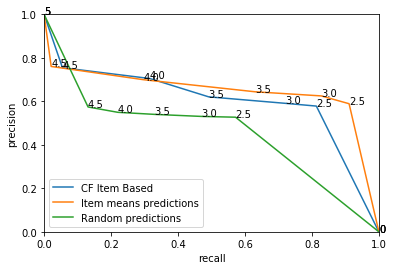

In [13]:
tresholds = [2.5, 3.0, 3.5, 4.0, 4.5]


# CF Item Based
values_item_based = precisons_recalls(predicted_item_based, tresholds)
values_item_based[0].append(0)
values_item_based[0].append(1)
values_item_based[1].append(0)
values_item_based[1].append(1)
values_item_based[0].sort()
values_item_based[1].sort(reverse=True)

precisons = values_item_based[0]
recalls = values_item_based[1]


print(precisons)
print(recalls)
plt.plot(recalls, precisons)
for r, p, t in zip(recalls, precisons, [0, 2.5, 3.0, 3.5, 4.0, 4.5, 5]):
    plt.text(r, p, t)

    
# item means based predictions
values_item_mean = precisons_recalls(predicted_item_mean, tresholds)

values_item_mean[0].append(0)
values_item_mean[0].append(1)
values_item_mean[1].append(0)
values_item_mean[1].append(1)
values_item_mean[0].sort()
values_item_mean[1].sort(reverse=True)

precisons = values_item_mean[0]
recalls = values_item_mean[1]

plt.plot(recalls, precisons)
for r, p, t in zip(recalls, precisons, [0, 2.5, 3.0, 3.5, 4.0, 4.5, 5]):
    plt.text(r, p, t)
    
# Random based predictions
values_item_random = precisons_recalls(predicted_random, tresholds)

values_item_random[0].append(0)
values_item_random[0].append(1)
values_item_random[1].append(0)
values_item_random[1].append(1)
values_item_random[0].sort()
values_item_random[1].sort(reverse=True)

precisons = values_item_random[0]
recalls = values_item_random[1]

plt.plot(recalls, precisons)
for r, p, t in zip(recalls, precisons, [0, 2.5, 3.0, 3.5, 4.0, 4.5, 5]):
    plt.text(r, p, t)
    
plt.xlim(0.0, 1)
plt.ylim(0.0, 1)
plt.xlabel('recall')
plt.ylabel('precision')

plt.legend(['CF Item Based', 'Item means predictions', 'Random predictions'], loc = 'lower left')